# 从零构建 大模型检索系统——RAG检索增强生成实验

RAG背景不在实验课上复述， 直接切入正题


In [1]:
# 实验及答题过程 提交设置
from env import set_user
USER_ID = ''
USER_TOKEN = ''
set_user(USER_ID, USER_TOKEN)

设置用户成功


# RAG总体框架

RAG = Retrieval + Augmented + Generation
三个核心步骤：

检索：从外部知识库找到相关文档

增强：将检索到的信息整合到提示中

生成：LLM基于增强后的提示生成回答

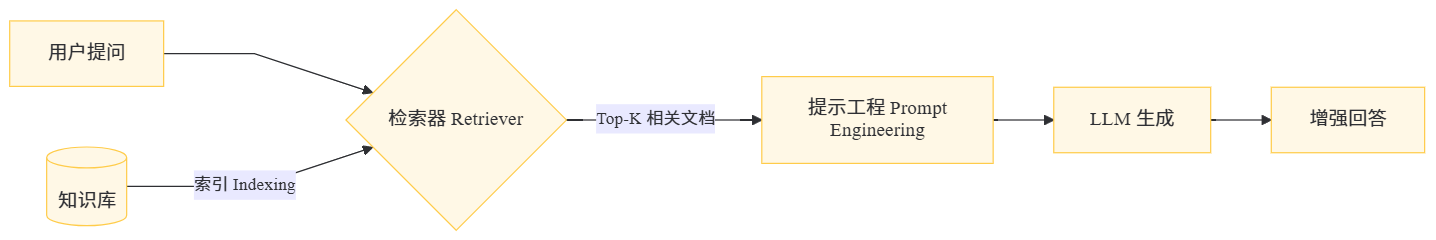


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple, http://mirrors.aliyun.com/pypi/simple/, http://pypi.douban.com/simple, http://pypi.mirrors.ustc.edu.cn/simple/, https://pypi.org/simple
ERROR: Could not find a version that satisfies the requirement faiss (from versions: none)
ERROR: No matching distribution found for faiss


In [2]:
!pip list | grep -E "mindspore|mindnlp|transformers|tokenizers|accelerate|torch|datasets"

accelerate               1.12.0
datasets                 4.5.0
geotorch                 0.3.0
tokenizers               0.19.1
torch                    2.4.1
torchdiffeq              0.2.4
torchmetrics             1.4.2
torchvision              0.19.1
transformers             4.40.0


# 数据准备与处理

我们使用 cmrc2018 数据集， 原因摘自 [rag_eval](https://github.com/ninehills/langeval/blob/main/examples/rag-eval/rag-eval-zh.ipynb): dureader_robust 和 cmrc2018 比较适合用于 RAG 评估。前者的回答过于简略，所以我们选择 cmrc2018 数据集进行评估。

因此数据准备一般包括两步

1. 真读取数据
2. 处理数据

### 下载和读取数据

In [2]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

from datasets import load_dataset

cmrc = load_dataset("cmrc2018")

print(f"数据集结构: {cmrc}")
print(f"测试集大小: {len(cmrc['test'])}")

/home/yangxl/software/conda/envs/torch24/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


数据集结构: DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'question', 'answers'],
        num_rows: 10142
    })
    validation: Dataset({
        features: ['id', 'context', 'question', 'answers'],
        num_rows: 3219
    })
    test: Dataset({
        features: ['id', 'context', 'question', 'answers'],
        num_rows: 1002
    })
})
测试集大小: 1002




从上面的结果中， 我们看到了数据集的结构， 接下来，看一个示例数据

#### TODO 1 查看数据例子

In [3]:
import json

# 查看一个样本
sample = cmrc["test"][0]

# 注意json库里若有中文， 需要使用 ensure_ascii=False
print(json.dumps(cmrc["test"][0], indent=4, ensure_ascii=False))

{
    "id": "TRIAL_800_QUERY_0",
    "context": "基于《跑跑卡丁车》与《泡泡堂》上所开发的游戏，由韩国Nexon开发与发行。中国大陆由盛大游戏运营，这是Nexon时隔6年再次授予盛大网络其游戏运营权。台湾由游戏橘子运营。玩家以水枪、小枪、锤子或是水炸弹泡封敌人(玩家或NPC)，即为一泡封，将水泡击破为一踢爆。若水泡未在时间内踢爆，则会从水泡中释放或被队友救援(即为一救援)。每次泡封会减少生命数，生命数耗完即算为踢爆。重生者在一定时间内为无敌状态，以踢爆数计分较多者获胜，规则因模式而有差异。以2V2、4V4随机配对的方式，玩家可依胜场数爬牌位(依序为原石、铜牌、银牌、金牌、白金、钻石、大师) ，可选择经典、热血、狙击等模式进行游戏。若游戏中离，则4分钟内不得进行配对(每次中离+4分钟)。开放时间为暑假或寒假期间内不定期开放，8人经典模式随机配对，采计分方式，活动时间内分数越多，终了时可依该名次获得奖励。",
    "question": "生命数耗完即算为什么？",
    "answers": {
        "text": [
            "踢爆"
        ],
        "answer_start": [
            127
        ]
    }
}


In [ ]:
# TODO：
print("\n样本示例:")

print(f"问题: {sample[?]}")
print(f"答案: {sample?}")
print(f"上下文长度: {?} 字符")
print(f"答案在上下文中的位置: {sample?}")


样本示例:
问题: 生命数耗完即算为什么？
答案: ['踢爆']
上下文长度: 381 字符
答案在上下文中的位置: [127]


预期输出如下：
```
样本示例:
问题: 生命数耗完即算为什么？
答案: ['踢爆']
上下文长度: 381 字符
答案在上下文中的位置: [127]
``` 

## 准备知识库

正式项目中，应该以 ______（哪些数据）  作为我们的向量索引的基础数据? 我们挑选其中的 context 嵌入到向量索引中。

请在下方cell中回答

注意看 cmrc 数据的获取特殊性，也就是一个上下文会有多组问答对， 节省上下文的存储空间

In [5]:
cmrc["test"][:3]

{'id': ['TRIAL_800_QUERY_0', 'TRIAL_800_QUERY_1', 'TRIAL_800_QUERY_2'],
 'context': ['基于《跑跑卡丁车》与《泡泡堂》上所开发的游戏，由韩国Nexon开发与发行。中国大陆由盛大游戏运营，这是Nexon时隔6年再次授予盛大网络其游戏运营权。台湾由游戏橘子运营。玩家以水枪、小枪、锤子或是水炸弹泡封敌人(玩家或NPC)，即为一泡封，将水泡击破为一踢爆。若水泡未在时间内踢爆，则会从水泡中释放或被队友救援(即为一救援)。每次泡封会减少生命数，生命数耗完即算为踢爆。重生者在一定时间内为无敌状态，以踢爆数计分较多者获胜，规则因模式而有差异。以2V2、4V4随机配对的方式，玩家可依胜场数爬牌位(依序为原石、铜牌、银牌、金牌、白金、钻石、大师) ，可选择经典、热血、狙击等模式进行游戏。若游戏中离，则4分钟内不得进行配对(每次中离+4分钟)。开放时间为暑假或寒假期间内不定期开放，8人经典模式随机配对，采计分方式，活动时间内分数越多，终了时可依该名次获得奖励。',
  '基于《跑跑卡丁车》与《泡泡堂》上所开发的游戏，由韩国Nexon开发与发行。中国大陆由盛大游戏运营，这是Nexon时隔6年再次授予盛大网络其游戏运营权。台湾由游戏橘子运营。玩家以水枪、小枪、锤子或是水炸弹泡封敌人(玩家或NPC)，即为一泡封，将水泡击破为一踢爆。若水泡未在时间内踢爆，则会从水泡中释放或被队友救援(即为一救援)。每次泡封会减少生命数，生命数耗完即算为踢爆。重生者在一定时间内为无敌状态，以踢爆数计分较多者获胜，规则因模式而有差异。以2V2、4V4随机配对的方式，玩家可依胜场数爬牌位(依序为原石、铜牌、银牌、金牌、白金、钻石、大师) ，可选择经典、热血、狙击等模式进行游戏。若游戏中离，则4分钟内不得进行配对(每次中离+4分钟)。开放时间为暑假或寒假期间内不定期开放，8人经典模式随机配对，采计分方式，活动时间内分数越多，终了时可依该名次获得奖励。',
  '基于《跑跑卡丁车》与《泡泡堂》上所开发的游戏，由韩国Nexon开发与发行。中国大陆由盛大游戏运营，这是Nexon时隔6年再次授予盛大网络其游戏运营权。台湾由游戏橘子运营。玩家以水枪、小枪、锤子或是水炸弹泡封敌人(玩家或NPC)，即为一泡封，将水泡击破为一踢爆。若水泡未在时间内踢爆

因此， 我们在建立索引时， 要注意去重

#### TODO 2 去重

In [ ]:
# 从 cmrc 中提取 context
texts_set = set()
texts = []
metadatas = []

# 主要使用这个变量
# TODO： 请实现去重
knowledge_base = []

for item in cmrc["test"]:
     
    # knowledge_base.append({"id": ？, "content": ？})      # key 统一， 请填写value
    pass

print(knowledge_base[0])

基于《跑跑卡丁车》与《泡泡堂》上所开发的游戏，由韩国Nexon开发与发行。中国大陆由盛大游戏运营，这是Nexon时隔6年再次授予盛大网络其游戏运营权。台湾由游戏橘子运营。玩家以水枪、小枪、锤子或是水炸弹泡封敌人(玩家或NPC)，即为一泡封，将水泡击破为一踢爆。若水泡未在时间内踢爆，则会从水泡中释放或被队友救援(即为一救援)。每次泡封会减少生命数，生命数耗完即算为踢爆。重生者在一定时间内为无敌状态，以踢爆数计分较多者获胜，规则因模式而有差异。以2V2、4V4随机配对的方式，玩家可依胜场数爬牌位(依序为原石、铜牌、银牌、金牌、白金、钻石、大师) ，可选择经典、热血、狙击等模式进行游戏。若游戏中离，则4分钟内不得进行配对(每次中离+4分钟)。开放时间为暑假或寒假期间内不定期开放，8人经典模式随机配对，采计分方式，活动时间内分数越多，终了时可依该名次获得奖励。
{'id': 'TRIAL_800_QUERY_0'}
256
{'id': 'TRIAL_800_QUERY_0', 'content': '基于《跑跑卡丁车》与《泡泡堂》上所开发的游戏，由韩国Nexon开发与发行。中国大陆由盛大游戏运营，这是Nexon时隔6年再次授予盛大网络其游戏运营权。台湾由游戏橘子运营。玩家以水枪、小枪、锤子或是水炸弹泡封敌人(玩家或NPC)，即为一泡封，将水泡击破为一踢爆。若水泡未在时间内踢爆，则会从水泡中释放或被队友救援(即为一救援)。每次泡封会减少生命数，生命数耗完即算为踢爆。重生者在一定时间内为无敌状态，以踢爆数计分较多者获胜，规则因模式而有差异。以2V2、4V4随机配对的方式，玩家可依胜场数爬牌位(依序为原石、铜牌、银牌、金牌、白金、钻石、大师) ，可选择经典、热血、狙击等模式进行游戏。若游戏中离，则4分钟内不得进行配对(每次中离+4分钟)。开放时间为暑假或寒假期间内不定期开放，8人经典模式随机配对，采计分方式，活动时间内分数越多，终了时可依该名次获得奖励。'}


预期输出如下：
```
{'id': 'TRIAL_800_QUERY_0', 'content': '基于《跑跑卡丁车》与《泡泡堂》上所开发的游戏，由韩国Nexon开发与发行。中国大陆由盛大游戏运营，这是Nexon时隔6年再次授予盛大网络其游戏运营权。台湾由游戏橘子运营。玩家以水枪、小枪、锤子或是水炸弹泡封敌人(玩家或NPC)，即为一泡封，将水泡击破为一踢爆。若水泡未在时间内踢爆，则会从水泡中释放或被队友救援(即为一救援)。每次泡封会减少生命数，生命数耗完即算为踢爆。重生者在一定时间内为无敌状态，以踢爆数计分较多者获胜，规则因模式而有差异。以2V2、4V4随机配对的方式，玩家可依胜场数爬牌位(依序为原石、铜牌、银牌、金牌、白金、钻石、大师) ，可选择经典、热血、狙击等模式进行游戏
```

**TO THINK** 上面的去重方式基于文本匹配， 理论上不是很好的方案， 但我们暂时这么用。


### 文档分块

通常来说， 我们使用的私有数据（如PDF， text文件）都是长文档， 如果以句子为单位，颗粒度又太细， 通常处理方案就是将长文档分割成一定长度的文本块chunk。 

分块函数需要两个控制参数， 一个是 块的长度， 另一个是重叠长度，确保段落间的语义连续性——包括剩下的字符数太少。

#### TODO 3 分块

In [ ]:
def chunk_documents(knowledge_base, chunk_size=300, overlap=50):
    """将长文档分割成块（如果需要）"""
    print("分割文档为块...")
    
    chunks = []
    for i, doc in enumerate(knowledge_base):
        content = doc["content"]

        # 如果文档长度超过chunk_size，则分割
        if len(content) > chunk_size:
            # TODO: 需要实现这个分割部分的代码
            # chunk_info变量
            pass
            
            # chunk_info = {
            #     "doc_id": doc["id"],
            #     "chunk_id": len(chunks),
            #     "content": chunk,
            #     "start_pos": start,
            #     "end_pos": end,
            #     "original_doc": doc
            # }
            # chunks.append(chunk_info)
                 
        else:
            # 短文档直接作为一个块
            chunk_info = {
                "doc_id": doc["id"],
                "chunk_id": len(chunks),
                "content": content,
                "start_pos": 0,
                "end_pos": len(content),
                "original_doc": doc
            }
            chunks.append(chunk_info)
    
    print(f"共创建 {len(chunks)} 个文本块")
    return chunks

chunks = chunk_documents(knowledge_base, chunk_size=300, overlap=50)
# 查看一些示例
print("\n前3个文档块示例:")
for i in range(3):
    print(f"块 {i}: {chunks[i]['content'][:100]}...")

分割文档为块...
共创建 648 个文本块

前3个文档块示例:
块 0: 基于《跑跑卡丁车》与《泡泡堂》上所开发的游戏，由韩国Nexon开发与发行。中国大陆由盛大游戏运营，这是Nexon时隔6年再次授予盛大网络其游戏运营权。台湾由游戏橘子运营。玩家以水枪、小枪、锤子或是水炸...
块 1: 序为原石、铜牌、银牌、金牌、白金、钻石、大师) ，可选择经典、热血、狙击等模式进行游戏。若游戏中离，则4分钟内不得进行配对(每次中离+4分钟)。开放时间为暑假或寒假期间内不定期开放，8人经典模式随机配...
块 2: 尤金袋鼠（"Macropus eugenii"）是袋鼠科中细小的成员，通常都是就袋鼠及有袋类的研究对象。尤金袋鼠分布在澳洲南部岛屿及西岸地区。由于牠们每季在袋鼠岛都大量繁殖，破坏了针鼹岛上的生活环境而...


预期输出如下：
```
分割文档为块...
共创建 648 个文本块

前3个文档块示例:
块 0: 基于《跑跑卡丁车》与《泡泡堂》上所开发的游戏，由韩国Nexon开发与发行。中国大陆由盛大游戏运营，这是Nexon时隔6年再次授予盛大网络其游戏运营权。台湾由游戏橘子运营。玩家以水枪、小枪、锤子或是水炸...
块 1: 序为原石、铜牌、银牌、金牌、白金、钻石、大师) ，可选择经典、热血、狙击等模式进行游戏。若游戏中离，则4分钟内不得进行配对(每次中离+4分钟)。开放时间为暑假或寒假期间内不定期开放，8人经典模式随机配...
块 2: 尤金袋鼠（"Macropus eugenii"）是袋鼠科中细小的成员，通常都是就袋鼠及有袋类的研究对象。尤金袋鼠分布在澳洲南部岛屿及西岸地区。由于牠们每季在袋鼠岛都大量繁殖，破坏了针鼹岛上的生活环境而...
```

## 文本向量化

现在我们有了文本块，如何快速找到与问题相关的块？
显然不能用简单的关键词匹配， 需要使用 Embedding 嵌入， 将句子转成表征。

#### TODO 4 加载模型
#### TODO 5 获取维度
#### TODO 6 生成文本的向量表示
#### TODO 7 批处理

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

class TextEmbedder:
    def __init__(self, model_name="bert-base-chinese"):
        print(f"加载模型: {model_name}")
        # TODO 4: API 
        self.tokenizer = None
        self.model = None
        
        # 如果有GPU，使用GPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()
        
        # TODO 5: 获取模型的嵌入维度
        # 在下方有代码，但有一些拼写错误需要修正
        print(f"嵌入维度: {self.embedding_dim}")
    
    def embed(self, text):
        """生成文本的向量表示"""
        # TODO 6： 参照TODO 5  完成
        inputs = self.？(
            text, 
            return_tensors="pt", 
            truncation=True, 
            padding=True, 
            max_length=512
        ).to(self.device)
        
        outputs = ?
        
        # 使用最后一层hidden state的mean pooling
        # [batch_size, seq_len, hidden_dim] -> [batch_size, hidden_dim]
        embeddings = outputs.last_hidden_state.mean(dim=1)
        
        # 归一化，便于计算余弦相似度
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        
        return embeddings.cpu()
    
    def batch_embed(self, texts, batch_size=32):
        """批量生成embedding"""
        embeddings = []
        
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            
            # TODO 7， 批处理， 参照TODO 6
            inputs = self.？(
                batch_texts,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=512
            ).to(self.device)
            
            batch_embeddings = ？
            
            embeddings.append(batch_embeddings.cpu())
            
            if i % (batch_size * 10) == 0:
                print(f"已处理 {min(i+batch_size, len(texts))}/{len(texts)} 个文本")
        
        return torch.cat(embeddings, dim=0)

# 初始化嵌入器
embedder = TextEmbedder("bert-base-chinese")

# 测试嵌入
test_texts = ["这是一个测试句子", "这是另一个测试"]
test_embeddings = embedder.batch_embed(test_texts)
print(f"测试嵌入形状: {test_embeddings.shape}")

加载模型: bert-base-chinese


/home/yangxl/software/conda/envs/torch24/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


嵌入维度: 768
已处理 2/2 个文本
测试嵌入形状: torch.Size([2, 768])


预期输出如下：
```
嵌入维度: 768
已处理 2/2 个文本
测试嵌入形状: torch.Size([2, 768])
```

#### TODO 5 的代码， 有拼写错误， 需要修改

sample_put = self.tokenizer("测试", return_tensors="pt")
with torch.no_rad():
    sample_output = self.model(**sample_input.to(self.device))
self.embedd_dim = sample_output.last_hidden_state.shape[-1]
print(f"嵌入维度: {self.embedding_dim}")

In [9]:
# 准备数据
chunk_texts = [chunk["content"] for chunk in chunks]
chunk_metadata = [{"chunk_id": chunk["chunk_id"], "doc_id": chunk["doc_id"]} for chunk in chunks]

print("正在生成所有chunk的embedding...")
chunk_embeddings = embedder.batch_embed(chunk_texts, batch_size=16)

正在生成所有chunk的embedding...
已处理 16/648 个文本
已处理 176/648 个文本
已处理 336/648 个文本
已处理 496/648 个文本
已处理 648/648 个文本


## 向量存储与检索

在本实验中，存储只使用最基础的python数据类型， 数据量少，因此不关注存储、读取的效率， add_embeddings函数已实现好

检索，则是将 query的embedding与 所存储的embedding计算相似度

#### TODO 8 批量 计算余弦相似度

#### TODO 9 转换成numpy,和按大小排序，找到top k

In [ ]:
import numpy as np
from typing import List, Dict, Any, Optional
import json

class VectorStore:
    def __init__(self, dimension: int):
        """
        简单的向量存储系统
        
        Args:
            dimension: 向量维度
        """
        self.dimension = dimension
        self.embeddings = []  # 存储向量
        self.texts = []  # 存储文本
        self.metadata = []  # 存储元数据
        
    def add_embeddings(self, embeddings, texts: List[str], metadata: Optional[List[Dict]] = None):
        """
        添加向量到存储
        
        Args:
            embeddings: 向量列表，可以是numpy数组或列表
            texts: 对应的文本列表
            metadata: 对应的元数据列表
        """
        # 转换为numpy数组
        if isinstance(embeddings, list):
            embeddings_np = np.array(embeddings)
        else:
            embeddings_np = embeddings
        
        # 确保维度正确
        if embeddings_np.shape[1] != self.dimension:
            raise ValueError(f"向量维度不匹配: 期望 {self.dimension}, 实际 {embeddings_np.shape[1]}")
        
        # 归一化向量（用于余弦相似度）
        norms = np.linalg.norm(embeddings_np, axis=1, keepdims=True)
        embeddings_norm = embeddings_np / norms
        
        # 添加到存储
        for i in range(len(embeddings_norm)):
            self.embeddings.append(embeddings_norm[i])
            self.texts.append(texts[i])
            if metadata:
                self.metadata.append(metadata[i])
            else:
                self.metadata.append({})
        
        print(f"已添加 {len(embeddings_np)} 个向量到存储，总大小: {len(self.embeddings)}")
    
    def search(self, query_embedding, k: int = 5, threshold: float = 0.0) -> List[Dict]:
        """
        检索最相似的k个文档
        
        Args:
            query_embedding: 查询向量
            k: 返回的结果数量
            threshold: 相似度阈值，只返回高于此值的结果
            
        Returns:
            相似度最高的k个结果列表
        """
        if len(self.embeddings) == 0:
            return []
        
        # 转换查询向量
        if isinstance(query_embedding, list):
            query_np = np.array(query_embedding)
        else:
            query_np = query_embedding
        
        # 归一化查询向量
        query_norm = query_np / np.linalg.norm(query_np)
        
        # TODO 8 计算余弦相似度（归一化后的向量点积）
        similarities = []
        for emb in self.embeddings:
            pass
        
        # TODO 9： 转换为numpy数组
        similarities_np = None

        # 获取top-k索引
        if k > len(similarities_np):
            k = len(similarities_np)
        
        # TODO 9： 找到top-k索引
        top_k_indices = None

        # 组装结果
        results = []
        for idx in top_k_indices:
            similarity = similarities_np[idx]
            if similarity < threshold:
                continue

            result = {
                "text": self.texts[idx],
                "metadata": self.metadata[idx],
                "score": float(similarity),
                "index": int(idx)
            }
            results.append(result)
        
        return results
    
    def search_batch(self, query_embeddings, k: int = 5) -> List[List[Dict]]:
        """
        批量检索
        
        Args:
            query_embeddings: 多个查询向量
            k: 每个查询返回的结果数量
            
        Returns:
            每个查询的结果列表
        """
        if isinstance(query_embeddings, list):
            queries_np = np.array(query_embeddings)
        else:
            queries_np = query_embeddings
        
        all_results = []
        for query in queries_np:
            results = self.search(query, k)
            all_results.append(results)
        
        return all_results
    
    def save(self, filepath: str):
        """
        保存向量存储到文件
        
        Args:
            filepath: 文件路径
        """
        # 将向量列表转换为numpy数组保存
        embeddings_array = np.array(self.embeddings)
        
        data_to_save = {
            "embeddings": embeddings_array.tolist(),
            "texts": self.texts,
            "metadata": self.metadata,
            "dimension": self.dimension
        }
        
        with open(filepath, "w", encoding="utf-8") as f:
            json.dump(data_to_save, f, ensure_ascii=False, indent=2)
        
        print(f"向量存储已保存到 {filepath}")
    
    def load(self, filepath: str):
        """
        从文件加载向量存储
        
        Args:
            filepath: 文件路径
        """
        with open(filepath, "r", encoding="utf-8") as f:
            data = json.load(f)
        
        # 重新创建向量列表
        self.embeddings = [np.array(emb) for emb in data["embeddings"]]
        self.texts = data["texts"]
        self.metadata = data["metadata"]
        self.dimension = data["dimension"]
        
        print(f"向量存储已加载，总向量数: {len(self.embeddings)}")
    
    def get_stats(self) -> Dict:
        """
        获取存储统计信息
        
        Returns:
            包含统计信息的字典
        """
        return {
            "total_vectors": len(self.embeddings),
            "dimension": self.dimension,
            "texts_count": len(self.texts),
            "metadata_count": len(self.metadata)
        }

# 创建向量存储
dimension = embedder.embedding_dim
vector_store = VectorStore(dimension)

print("正在构建向量索引...")
vector_store.add_embeddings(chunk_embeddings, chunk_texts, chunk_metadata)


正在构建向量索引...
已添加 648 个向量到存储，总大小: 648


预期输出如下：
```
正在构建向量索引...
已添加 648 个向量到存储，总大小: 648
```


In [11]:

# 测试检索
test_question = "跑跑卡丁车是谁开发的？"
test_question_embedding = embedder.embed(test_question)
results = vector_store.search(test_question_embedding, k=3)

print(f"\n测试问题: '{test_question}'")
print("检索结果:")
print(len(results))
for i, result in enumerate(results):
    print(f"{i+1}. 相似度: {result['score']:.4f}")
    print(f"   文本: {result['text'][:100]}...")
    print(f"   元数据: {result['metadata']}")
    print()


测试问题: '跑跑卡丁车是谁开发的？'
检索结果:
3
1. 相似度: 0.7799
   文本: 李晨（），中国大陆男演员，出生于北京，毕业于北京群星艺术学院。参加综艺节目《奔跑吧兄弟》而走红，因为在节目中担当能力者，有「大黑牛」的称号。也因为在跑男团中年纪较大，所以也有著「老李头」的称呼。201...
   元数据: {'chunk_id': 625, 'doc_id': 'TRIAL_948_QUERY_0'}

2. 相似度: 0.7786
   文本: 世界裸体自行车游行组织（英文：World Naked Bike Ride，缩写：WNBR）是一个国际性的可穿可不穿（cloth-optional）的自行车组织，参与者集体规划及聚会，共同以人力交通工具...
   元数据: {'chunk_id': 44, 'doc_id': 'TRIAL_861_QUERY_0'}

3. 相似度: 0.7782
   文本: 基于《跑跑卡丁车》与《泡泡堂》上所开发的游戏，由韩国Nexon开发与发行。中国大陆由盛大游戏运营，这是Nexon时隔6年再次授予盛大网络其游戏运营权。台湾由游戏橘子运营。玩家以水枪、小枪、锤子或是水炸...
   元数据: {'chunk_id': 0, 'doc_id': 'TRIAL_800_QUERY_0'}



In [12]:
test_question = "玩家用什么泡封敌人？"
test_question_embedding = embedder.embed(test_question)
results = vector_store.search(test_question_embedding, k=3)
print(f"\n测试问题: '{test_question}'")
print("检索结果:")
print(len(results))
for i, result in enumerate(results):
    print(f"{i+1}. 相似度: {result['score']:.4f}")
    print(f"   文本: {result['text'][:100]}...")
    print(f"   元数据: {result['metadata']}")
    print()


测试问题: '玩家用什么泡封敌人？'
检索结果:
3
1. 相似度: 0.7810
   文本: 序为原石、铜牌、银牌、金牌、白金、钻石、大师) ，可选择经典、热血、狙击等模式进行游戏。若游戏中离，则4分钟内不得进行配对(每次中离+4分钟)。开放时间为暑假或寒假期间内不定期开放，8人经典模式随机配...
   元数据: {'chunk_id': 1, 'doc_id': 'TRIAL_800_QUERY_0'}

2. 相似度: 0.7765
   文本: 基于《跑跑卡丁车》与《泡泡堂》上所开发的游戏，由韩国Nexon开发与发行。中国大陆由盛大游戏运营，这是Nexon时隔6年再次授予盛大网络其游戏运营权。台湾由游戏橘子运营。玩家以水枪、小枪、锤子或是水炸...
   元数据: {'chunk_id': 0, 'doc_id': 'TRIAL_800_QUERY_0'}

3. 相似度: 0.7632
   文本: 设定。【原作】【改编】拥有模仿人类样貌科技力能够轻易渗透而入，需要大量的水份生存才能得以生存的神秘种族。【原作】【改编】为了对抗气化人所开发出的可变巨型战舰，借由进入『挑战模式』（バトロードフォーメー...
   元数据: {'chunk_id': 159, 'doc_id': 'TRIAL_126_QUERY_0'}



预期输出如下：
```
测试问题: '跑跑卡丁车是谁开发的？'
检索结果:
3
1. 相似度: 0.7799
   文本: 李晨（），中国大陆男演员，出生于北京，毕业于北京群星艺术学院。参加综艺节目《奔跑吧兄弟》而走红，因为在节目中担当能力者，有「大黑牛」的称号。也因为在跑男团中年纪较大，所以也有著「老李头」的称呼。201...
   元数据: {'chunk_id': 625, 'doc_id': 'TRIAL_948_QUERY_0'}

2. 相似度: 0.7786
   文本: 世界裸体自行车游行组织（英文：World Naked Bike Ride，缩写：WNBR）是一个国际性的可穿可不穿（cloth-optional）的自行车组织，参与者集体规划及聚会，共同以人力交通工具...
   元数据: {'chunk_id': 44, 'doc_id': 'TRIAL_861_QUERY_0'}

3. 相似度: 0.7782
   文本: 基于《跑跑卡丁车》与《泡泡堂》上所开发的游戏，由韩国Nexon开发与发行。中国大陆由盛大游戏运营，这是Nexon时隔6年再次授予盛大网络其游戏运营权。台湾由游戏橘子运营。玩家以水枪、小枪、锤子或是水炸...
   元数据: {'chunk_id': 0, 'doc_id': 'TRIAL_800_QUERY_0'}
```

和 

```
测试问题: '玩家用什么泡封敌人？'
检索结果:
3
1. 相似度: 0.7810
   文本: 序为原石、铜牌、银牌、金牌、白金、钻石、大师) ，可选择经典、热血、狙击等模式进行游戏。若游戏中离，则4分钟内不得进行配对(每次中离+4分钟)。开放时间为暑假或寒假期间内不定期开放，8人经典模式随机配...
   元数据: {'chunk_id': 1, 'doc_id': 'TRIAL_800_QUERY_0'}

2. 相似度: 0.7765
   文本: 基于《跑跑卡丁车》与《泡泡堂》上所开发的游戏，由韩国Nexon开发与发行。中国大陆由盛大游戏运营，这是Nexon时隔6年再次授予盛大网络其游戏运营权。台湾由游戏橘子运营。玩家以水枪、小枪、锤子或是水炸...
   元数据: {'chunk_id': 0, 'doc_id': 'TRIAL_800_QUERY_0'}

3. 相似度: 0.7632
   文本: 设定。【原作】【改编】拥有模仿人类样貌科技力能够轻易渗透而入，需要大量的水份生存才能得以生存的神秘种族。【原作】【改编】为了对抗气化人所开发出的可变巨型战舰，借由进入『挑战模式』（バトロードフォーメー...
   元数据: {'chunk_id': 159, 'doc_id': 'TRIAL_126_QUERY_0'}
```

## 提示工程与答案生成

前面部分实现了 检索， 接下来， 就是基于检索结果的 增强生成（大模型回答）

请在下方cell中回答， 整体包含哪四步（代码里的注释有写）


#### TODO 10 请一一实现调用

出于方便， 我使用了ollama封装的大模型

In [ ]:
class PromptBuilder:
    def __init__(self):
        # 中文RAG提示模板
        self.template = """你是一个智能问答助手，请根据提供的参考信息回答问题。

参考信息：
{context}

问题：{question}

请根据参考信息回答问题。如果参考信息中没有相关信息，请如实回答"根据提供的参考信息，我无法回答这个问题"。回答时请尽量简洁准确。"""

    def build_prompt(self, question, retrieved_results, max_context_length=2000):
        """构建RAG提示"""
        # 合并检索到的文档，直到达到最大长度
        context_parts = []
        total_length = 0
        
        for result in retrieved_results:
            text = result["text"]
            if total_length + len(text) <= max_context_length:
                context_parts.append(text)
                total_length += len(text)
            else:
                # 如果已经达到最大长度，只添加一部分
                remaining = max_context_length - total_length
                if remaining > 100:  # 只添加有意义的片段
                    context_parts.append(text[:remaining] + "...")
                break
        
        context = "\n\n".join(context_parts)
        
        # 构建完整提示
        prompt = self.template.format(context=context, question=question)
        
        return prompt, context


class SimpleGenerator:
    """简化版的生成器，实际应用中应使用真正的LLM"""
    def __init__(self):
        self.name = "Simple Generator"
    
    def generate(self, prompt):
        """模拟生成过程"""
        # 在实际应用中，这里应该调用真正的LLM API
        # 如OpenAI API、本地部署的LLM等
        
        # 简化的模拟：返回提示的前100个字符
        return f"模拟生成答案（基于提示）: {prompt[:100]}..."
    

# from transformers import AutoTokenizer, AutoModelForCausalLM
# class RAGGenerator:
#     """应用中使用某个模型"""
    
#     def __init__(self, model_name="Qwen/Qwen2.5-0.5B-Instruct"):
#         self.name = "Simple Generator"
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         # 加载Qwen 2.5 7B模型及其tokenizer
#         self.tokenizer = AutoTokenizer.from_pretrained(model_name)
#         self.model = AutoModelForCausalLM.from_pretrained(model_name).to(self.device)
    
#     def generate(self, prompt, max_length=3000):
#         """使用Qwen 2.5 7B模型生成文本"""
        
#         # 对输入提示进行编码
#         inputs = self.tokenizer(prompt, return_tensors="pt")
        
#         # 生成文本
#         outputs = self.model.generate(inputs["input_ids"].to(self.device), max_length=max_length, num_return_sequences=1)
        
#         # 解码并返回生成的文本
#         generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
#         return generated_text
    

import ollama
class OllamaGenerator:
    """使用 Ollama 接口调用Qwen 2.5 7B模型"""
    
    def __init__(self, model_name="qwen2.5"):
        self.name = "Simple Generator"
        self.model_name = model_name
    
    def generate(self, prompt, max_length=100):
        """使用 Ollama API 生成文本"""
        
        # 调用 Ollama 的 API 进行生成
        stream = ollama.chat(model=self.model_name, messages=[{"role": "user", "content": prompt}], stream=True,)
        
        # 获取生成的文本
        generated_text = ''
        for chunk in stream:
            generated_text += chunk['message']['content']
        
        # 返回生成的文本
        return generated_text[:max_length]  # 截取最大字符数


class RAGSystem:
    def __init__(self, embedder, vector_store, generator=None):
        self.embedder = embedder
        self.vector_store = vector_store
        self.prompt_builder = PromptBuilder()
        
        # 如果没有提供生成器，使用简单版本
        if generator:
            self.generator = generator
        else:
            self.generator = SimpleGenerator()
    
    def query(self, question, k=5, max_context_length=2000):
        """完整的RAG查询流程"""
        print(f"处理问题: '{question}'")
        
        # TODO 10  1. 将问题转换为embedding
        question_emb = None
        
        # TODO 10  2. 检索相关文档
        retrieved_results = None
        
        print(f"检索到 {len(retrieved_results)} 个相关文档")
        
        # TODO 10  3. 构建增强提示
        prompt, context = None
        
        # TODO 10  4. 生成答案
        answer = None
        
        # 返回完整结果
        return {
            "question": question,
            "answer": answer,
            "retrieved_docs": retrieved_results,
            "context_used": context,
            "prompt": prompt[:200] + "..." if len(prompt) > 200 else prompt
        }

# 创建RAG系统
rag_system = RAGSystem(embedder, vector_store, generator=OllamaGenerator())

# 测试查询
test_questions = [
    "跑跑卡丁车是谁开发的？",
    "跑跑卡丁车是谁代理的？",
    "伏尔泰的朋友们是列夫 托尔斯泰写的吗？"
]

for question in test_questions:
    print("\n" + "="*50)
    result = rag_system.query(question, k=3)
    print(f"问题: {result['question']}")
    print(f"答案: {result['answer']}")
    print(f"使用的上下文长度: {len(result['context_used'])} 字符")


处理问题: '跑跑卡丁车是谁开发的？'
检索到 3 个相关文档
问题: 跑跑卡丁车是谁开发的？
答案: 《跑跑卡丁车》是由韩国Nexon开发与发行的游戏。
使用的上下文长度: 904 字符

处理问题: '跑跑卡丁车是谁代理的？'
检索到 3 个相关文档
问题: 跑跑卡丁车是谁代理的？
答案: 根据提供的参考信息，我无法回答这个问题。
使用的上下文长度: 904 字符

处理问题: '伏尔泰的朋友们是列夫 托尔斯泰写的吗？'
检索到 3 个相关文档
问题: 伏尔泰的朋友们是列夫 托尔斯泰写的吗？
答案: 根据提供的参考信息，伏尔泰的朋友们并非列夫·托尔斯泰所写，而是伊夫林·比阿特丽斯·霍尔以笔名S.G. Tallentyre写作的一部作品。
使用的上下文长度: 840 字符


预期输出如下：
```
==================================================
处理问题: '跑跑卡丁车是谁开发的？'
检索到 3 个相关文档
问题: 跑跑卡丁车是谁开发的？
答案: 《跑跑卡丁车》是由韩国Nexon开发与发行的游戏。
使用的上下文长度: 904 字符

==================================================
处理问题: '跑跑卡丁车是谁代理的？'
检索到 3 个相关文档
问题: 跑跑卡丁车是谁代理的？
答案: 根据提供的参考信息，我无法回答这个问题。
使用的上下文长度: 904 字符

==================================================
处理问题: '伏尔泰的朋友们是列夫 托尔斯泰写的吗？'
检索到 3 个相关文档
问题: 伏尔泰的朋友们是列夫 托尔斯泰写的吗？
答案: 根据提供的参考信息，伏尔泰的朋友们并非列夫·托尔斯泰所写，而是伊夫林·比阿特丽斯·霍尔以笔名S.G. Tallentyre写作的一部作品。
使用的上下文长度: 840 字符
```

我们知道，有一条数据写的是“基于《跑跑卡丁车》与《泡泡堂》上所开发的游戏，由韩国Nexon开发与发行。中国大陆由盛大游戏运营”

因此， 问题一'跑跑卡丁车是谁开发的？'和问题二'跑跑卡丁车是谁代理的？'， 应该都能回答成功， 但显示第二个问题失败， 我们看看原因

##### TODO 11 看一看

In [14]:
question = '跑跑卡丁车是谁开发的？'
result = rag_system.query(question, k=3)
print(f"问题: {result['question']}")
print(f"答案: {result['answer']}")
for i, doc in enumerate(result['retrieved_docs']):
    print(i+1, doc['text'][:50])

处理问题: '跑跑卡丁车是谁开发的？'
检索到 3 个相关文档
问题: 跑跑卡丁车是谁开发的？
答案: 《跑跑卡丁车》是由韩国Nexon开发并发行的游戏。
1 李晨（），中国大陆男演员，出生于北京，毕业于北京群星艺术学院。参加综艺节目《奔跑吧兄弟》而走红，因为
2 世界裸体自行车游行组织（英文：World Naked Bike Ride，缩写：WNBR）是一个国际
3 基于《跑跑卡丁车》与《泡泡堂》上所开发的游戏，由韩国Nexon开发与发行。中国大陆由盛大游戏运营，这


In [15]:
question = '跑跑卡丁车是谁代理的？'
result = rag_system.query(question, k=3)
print(f"问题: {result['question']}")
print(f"答案: {result['answer']}")
for i, doc in enumerate(result['retrieved_docs']):
    print(i+1, doc['text'][:50])

处理问题: '跑跑卡丁车是谁代理的？'
检索到 3 个相关文档
问题: 跑跑卡丁车是谁代理的？
答案: 根据提供的参考信息，我无法回答这个问题。参考信息中并未提及关于跑跑卡丁车代理的相关内容。
1 上海美特斯邦威服饰股份有限公司（）于1995年创办于浙江省温州市。主要研发、设计、生产、销售休闲类服
2 世界裸体自行车游行组织（英文：World Naked Bike Ride，缩写：WNBR）是一个国际
3 李晨（），中国大陆男演员，出生于北京，毕业于北京群星艺术学院。参加综艺节目《奔跑吧兄弟》而走红，因为


In [ ]:
# TODO 11 我们修改一下问题二， 将代理换成原文的运营二字
question = '跑跑卡丁车是谁运营的？'
result = rag_system.query(question, k=3)
print(f"问题: {result['question']}")
print(f"答案: {result['answer']}")
for i, doc in enumerate(result['retrieved_docs']):
    print(i+1, doc['text'][:50])

处理问题: '跑跑卡丁车是谁运营的？'
检索到 3 个相关文档
问题: 跑跑卡丁车是谁运营的？
答案: 中国大陆由盛大游戏运营。
1 李晨（），中国大陆男演员，出生于北京，毕业于北京群星艺术学院。参加综艺节目《奔跑吧兄弟》而走红，因为
2 基于《跑跑卡丁车》与《泡泡堂》上所开发的游戏，由韩国Nexon开发与发行。中国大陆由盛大游戏运营，这
3 emale Pop Vocal Performance）的提名。娜塔莎第二张专辑（2007）娜塔莎有


In [ ]:
# 再来看一看大模型本身的回答
SimpleGenerator().generate('跑跑卡丁车是谁代理的？')

'《跑跑卡丁车》是由腾讯游戏代理运营的游戏。这款游戏是一款经典的赛车竞速类网络游戏，以其丰富的赛道、多元化的车辆以及趣味性的比赛模式受到了广大玩家的喜爱。'

### 结果分析

通过 “开发”、“运营”、“代理” 的一词之差， 我们可以看到此处 RAG的瓶颈在于 embedding的检索， embedding 无法区分“代理”、“运营”是同一含义

## 评估

以上， 我们就从零实现了一个最基本的RAG流程系统

接下来，我们对该系统的正确率进行简单评估， 只使用 accuracy 指标


In [ ]:
class RAGEvaluator:
    def __init__(self, rag_system, test_dataset, num_samples=50):
        self.rag_system = rag_system
        self.test_dataset = test_dataset
        self.num_samples = num_samples
        
    def evaluate_retrieval(self):
        """评估检索模块"""
        print("评估检索模块...")
        
        retrieval_scores = []
        
        # 从测试集中取样评估
        for i in range(min(self.num_samples, len(self.test_dataset))):
            item = self.test_dataset[i]
            question = item["question"]
            correct_context = item["context"]
            
            # 检索相关文档
            question_emb = self.rag_system.embedder.embed(question)
            retrieved_results = self.rag_system.vector_store.search(question_emb, k=5)
            
            # 检查是否检索到正确答案所在的文档
            retrieval_hit = False
            for result in retrieved_results:
                if correct_context[:100] in result["text"]:  # 简化检查
                    retrieval_hit = True
                    break
            
            retrieval_scores.append(1 if retrieval_hit else 0)
            
            if i % 10 == 0:
                print(f"已评估 {i+1}/{self.num_samples} 个问题")
        
        retrieval_accuracy = np.mean(retrieval_scores)
        print(f"检索准确率: {retrieval_accuracy:.2%} ({sum(retrieval_scores)}/{len(retrieval_scores)})")
        
        return retrieval_accuracy
    
    def evaluate_end_to_end(self, use_simple_metric=True):
        """端到端评估（简化版）"""
        print("端到端评估...")
        
        evaluation_results = []
        
        for i in range(min(self.num_samples, len(self.test_dataset))):
            item = self.test_dataset[i]
            question = item["question"]
            correct_answers = item["answers"]["text"]
            
            # 使用RAG系统回答问题
            result = self.rag_system.query(question, k=3)
            generated_answer = result["answer"]
            
            # 简化评估：检查生成的答案是否包含正确答案中的关键词
            score = 0
            if correct_answers and len(correct_answers) > 0:
                correct_answer = correct_answers[0]
                
                if use_simple_metric:
                    # 简单评估：检查重叠词
                    correct_words = set(correct_answer)
                    generated_words = set(generated_answer)
                    overlap = len(correct_words & generated_words)
                    score = min(1.0, overlap / max(len(correct_words), 1))
                else:
                    # 在实际应用中，应该使用更复杂的评估指标
                    # 如ROUGE、BLEU或人工评估
                    score = 0.5  # 占位符
            
            evaluation_results.append({
                "question": question,
                "correct_answer": correct_answers[0] if correct_answers else "",
                "generated_answer": generated_answer,
                "score": score
            })
            
            if i % 10 == 0:
                print(f"已评估 {i+1}/{self.num_samples} 个问题")
        
        avg_score = np.mean([r["score"] for r in evaluation_results])
        print(f"平均得分: {avg_score:.4f}")
        
        # 显示一些示例
        print("\n评估示例:")
        for i in range(min(3, len(evaluation_results))):
            r = evaluation_results[i]
            print(f"问题: {r['question']}")
            print(f"正确答案: {r['correct_answer']}")
            print(f"生成答案: {r['generated_answer'][:100]}...")
            print(f"得分: {r['score']:.2f}")
            print()
        
        return evaluation_results, avg_score

# 执行评估
evaluator = RAGEvaluator(rag_system, cmrc["test"], num_samples=50)
retrieval_accuracy = evaluator.evaluate_retrieval()

评估检索模块...
已评估 1/50 个问题
已评估 11/50 个问题
已评估 21/50 个问题
已评估 31/50 个问题
已评估 41/50 个问题
检索准确率: 74.00% (37/50)


预期输出如下
```
评估检索模块...
已评估 1/50 个问题
已评估 11/50 个问题
已评估 21/50 个问题
已评估 31/50 个问题
已评估 41/50 个问题
检索准确率: 74.00% (37/50)
```

In [ ]:
retrieval_accuracy = evaluator.evaluate_end_to_end()
# 预期输出 得分 0.94

# 参考及致谢

本代码中使用了以下内容

1. [MindTinyRAG](https://github.com/ResDream/MindTinyRAG/tree/main)
2. [RAG-Eval](https://github.com/ninehills/langeval/blob/main/examples/rag-eval/rag-eval-zh.ipynb)

